# Merck - Molecular Activity

### Goal 
The challenge is to predict the activity value for each molecule/data set combination in the test set. To keep predictions for molecules unique to each data set, a data set identifier has been prepended to each molecule ID (e.g., "ACT1_" or "ACT8_").

### Data
The Training and Test Sets each consist of 15 biological activity data sets in comma separated value (CSV) format.
 Each row of data corresponds to a chemical structure represented by molecular descriptors
es

The training files are of theform

Column 1: Mole  cule ID
Column 2: Activity. Note that these are raw activity values and different data sets can have activity measured in differen  t units.
Column 3-end: Molecular descriptors  /features
The test files are in the same format with Column 2 removed.

Molecule IDs and descriptor names are global to all data sets. Thus some molecules will appear in multiple data sets, as will some " or "ACT8_").).

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [14]:
data =pd.read_csv("data/ACT1_clean.csv")

In [15]:
data.set_index("MOLECULE",inplace=True)

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [17]:
# ---------- Model (regression) ----------
class ProteinRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, hidden_dim3, dropout_rate):
        super(ProteinRegressor, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc3 = nn.Linear(hidden_dim2, hidden_dim3)
        self.fc4 = nn.Linear(hidden_dim3, 1)    # single continuous output

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)

        x = self.relu(self.fc2(x))
        x = self.dropout(x)

        x = self.relu(self.fc3(x))
        x = self.dropout(x)

        x = self.fc4(x)   # no activation (regression)
        return x

# ---------- Dataset (regression labels as float) ----------
class ProteinDataset(Dataset):
    def __init__(self, df: pd.DataFrame, label_column: str):
        # features: all columns except label column
        self.embeddings = torch.tensor(df.drop(columns=[label_column]).values, dtype=torch.float32)
        # target: float tensor (shape: [N,])
        self.labels = torch.tensor(df[label_column].values, dtype=torch.float32)

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, idx):
        return self.embeddings[idx], self.labels[idx]

# ---------- Training loop ----------
def train_model(model, data_loader, criterion, optimizer, device, epochs=20):
    model.train()
    model.to(device)
    for epoch in range(epochs):
        running_loss = 0.0
        for batch in data_loader:
            inputs, labels = batch
            inputs = inputs.to(device)
            labels = labels.to(device).unsqueeze(1)  # shape [batch,1]

            optimizer.zero_grad()
            outputs = model(inputs)                  # shape [batch,1]
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(data_loader.dataset)
        print(f"Epoch [{epoch+1}/{epochs}] - Train Loss (MSE): {epoch_loss:.6f}")

# ---------- Evaluation loop ----------
def evaluate_model(model, data_loader, criterion, device, show_plot=False):
    model.eval()
    model.to(device)

    preds = []
    trues = []
    total_loss = 0.0

    with torch.no_grad():
        for batch in data_loader:
            inputs, labels = batch
            inputs = inputs.to(device)
            labels = labels.to(device).unsqueeze(1).float()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)

            preds.append(outputs.cpu().numpy())
            trues.append(labels.cpu().numpy())

    preds = np.vstack(preds).ravel()
    trues = np.vstack(trues).ravel()

    mse = mean_squared_error(trues, preds)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(trues, preds)
    r2 = r2_score(trues, preds)
    avg_loss = total_loss / len(data_loader.dataset)

    print(f"Eval Loss (MSE): {avg_loss:.6f}")
    print(f"MSE: {mse:.6f}, RMSE: {rmse:.6f}, MAE: {mae:.6f}, R2: {r2:.4f}")

    if show_plot:
        # scatter true vs pred
        plt.figure(figsize=(6,6))
        sns.scatterplot(x=trues, y=preds, s=20)
        mn, mx = min(trues.min(), preds.min()), max(trues.max(), preds.max())
        plt.plot([mn, mx], [mn, mx], linestyle='--')  # identity line
        plt.xlabel("True")
        plt.ylabel("Predicted")
        plt.title("True vs Predicted")
        plt.show()

    return {'mse': mse, 'rmse': rmse, 'mae': mae, 'r2': r2}

In [22]:
data.shape[1]

179

Epoch [1/50] - Train Loss (MSE): 2.409288
Epoch [2/50] - Train Loss (MSE): 1.145100
Epoch [3/50] - Train Loss (MSE): 0.917712
Epoch [4/50] - Train Loss (MSE): 0.833112
Epoch [5/50] - Train Loss (MSE): 0.742145
Epoch [6/50] - Train Loss (MSE): 0.658243
Epoch [7/50] - Train Loss (MSE): 0.592767
Epoch [8/50] - Train Loss (MSE): 0.538291
Epoch [9/50] - Train Loss (MSE): 0.479203
Epoch [10/50] - Train Loss (MSE): 0.434996
Epoch [11/50] - Train Loss (MSE): 0.395415
Epoch [12/50] - Train Loss (MSE): 0.359505
Epoch [13/50] - Train Loss (MSE): 0.336700
Epoch [14/50] - Train Loss (MSE): 0.304142
Epoch [15/50] - Train Loss (MSE): 0.288626
Epoch [16/50] - Train Loss (MSE): 0.273535
Epoch [17/50] - Train Loss (MSE): 0.264474
Epoch [18/50] - Train Loss (MSE): 0.246775
Epoch [19/50] - Train Loss (MSE): 0.242760
Epoch [20/50] - Train Loss (MSE): 0.236724
Epoch [21/50] - Train Loss (MSE): 0.232010
Epoch [22/50] - Train Loss (MSE): 0.226709
Epoch [23/50] - Train Loss (MSE): 0.221608
Epoch [24/50] - Trai

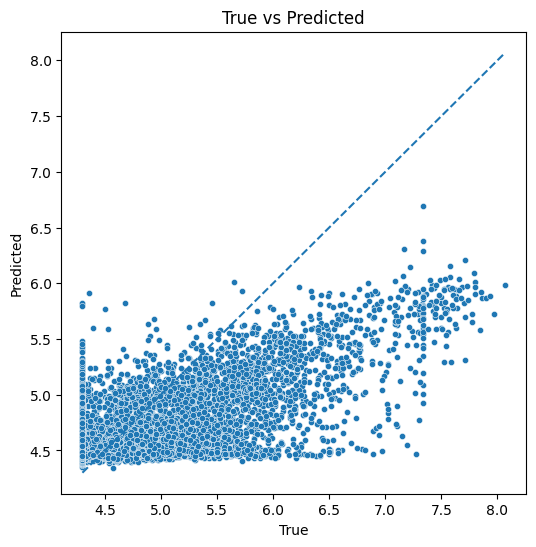

In [29]:
# ---------- Example usage (replace `data` with your DataFrame) ----------
input_dim = 178
hidden_dim1 = 200
hidden_dim2 = 100
hidden_dim3 = 50
dropout_rate = 0.5

model = ProteinRegressor(input_dim, hidden_dim1, hidden_dim2, hidden_dim3, dropout_rate)

criterion = nn.MSELoss() 
optimizer = optim.Adam(model.parameters(), lr=0.001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

label_column = "Act"   # continuous target

# NOTE: regression -> cannot stratify. Use random split.
train_df, test_df = train_test_split(data, test_size=0.3, random_state=42)

train_dataset = ProteinDataset(train_df, label_column)
test_dataset = ProteinDataset(test_df, label_column)

train_loader = DataLoader(train_dataset, batch_size=50, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=50, shuffle=False)

# Train
train_model(model, train_loader, criterion, optimizer, device, epochs=50)

# Evaluate
metrics = evaluate_model(model, test_loader, criterion, device, show_plot=True)
